# Libraries

In [3]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import cv2
import os
import torchvision.models as models
import torch.optim as optim

from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from torch.utils.data import Dataset, DataLoader, sampler
from sklearn.model_selection import KFold  # K-Folds cross-validator for model evaluation
from typing import Tuple, List, Union  # Typing for type hinting in function signatures



# Functions

In [4]:
def train_one_epoch(model : torch.nn.Module,
                    optimizer : torch.optim.Optimizer,
                    data_loader : torch.utils.data.DataLoader,
                    device : str,
                    dtype : type = torch.float32,
                    scaler : torch.cuda.amp.GradScaler = None ) -> Tuple[float, float]:
    """
    Trains the model for one epoch using the provided data_loader.

    Args:
    - model: The neural network model to be trained.
    - optimizer: The optimizer used for training the model.
    - data_loader: The data loader providing training data.
    - device: The device on which the training will be performed (e.g., 'cpu' or 'cuda').
    - dtype (torch.dtype, optional): The data type used for the tensors (default: torch.float32).
    - scaler (torch.cuda.amp.GradScaler, optional): Gradient scaler for mixed precision training (default: None).

    Returns:
    - tuple: A tuple containing the average loss per sample and the accuracy for the epoch.
    """
    model.train()
    total_loss = 0.0
    correct = 0
    total_samples = 0

    for x, y in tqdm(data_loader):
        x, y = x.to(device=device, dtype=dtype), y.to(device=device, dtype=torch.long)
        optimizer.zero_grad()
        with autocast(enabled=(scaler is not None)):
            scores = model(x)
            loss = F.cross_entropy(scores, y)
        if scaler is not None:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()
        total_loss += loss.item() * x.size(0)
        _, predicted = scores.max(1)
        correct += (predicted == y).sum().item()
        total_samples += x.size(0)

    return total_loss / total_samples, correct / total_samples


def accuracy(loader: torch.utils.data.DataLoader,
            model : torch.nn.Module,
            device : str,
            dtype : type = torch.float32) -> float:
    """
    Calculates accuracy on a given data loader using the provided model.

    Args:
    - loader: The data loader to calculate accuracy on.
    - model: The neural network model to evaluate.
    - device: The device on which the evaluation will be performed (e.g., 'cpu' or 'cuda').
    - dtype (torch.dtype, optional): The data type used for the tensors (default: torch.float32).

    Returns:
    - float: The accuracy of the model on the given data loader.
    """
    print(f'Checking accuracy')

    model.eval()
    num_correct = 0
    num_samples = 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device=device, dtype=dtype), y.to(device=device, dtype=torch.long)

            scores = model(x)
            _, preds = scores.max(1)
            
            num_correct += (preds == y).sum().item()
            num_samples += preds.size(0)
        
        accuracy = num_correct / num_samples if num_samples > 0 else 0
        print(f'Got {num_correct} / {num_samples} correct ({100 * accuracy:.2f}%)')
    
    return accuracy


def get_pretrained_model(model_name: str) -> torch.nn.Module:
    """
    Loads a pre-trained model based on the specified model name.

    Args:
    - model_name (str): The name of the pre-trained model ('vgg16', 'resnet50', 'inceptionv3', or 'mobilenetv2').

    Returns:
    - torch.nn.Module: The pre-trained model specified by the model_name.
    """
    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)
    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)
    elif model_name == 'inceptionv3':
        model = models.inception_v3(pretrained=True)
    else:
        raise ValueError('Model not recognized. Choose from vgg16, resnet50, inceptionv3, or mobilenetv2')
    
    return model

def convert(x):
    if x=='A':
        return 0
    if x=='B':
        return 1
    if x=='C':
        return 2

# Load data

## Load labels

In [5]:
directory = '../data/CEM_database/'

with open(directory + 'blasts.pkl', 'rb') as f:
    blast_information = pickle.load(f)

n_data = len(blast_information)

y_ICM = np.zeros(n_data, dtype=int)
y_TE = np.zeros(n_data, dtype=int)
y_Exp = np.zeros(n_data, dtype=int)

y_ICM_letras = []
y_TE_letras = []
y_Exp_letras = []

for i in np.arange(1,n_data-1):
  label_ICM = convert(blast_information[str(i)][0][2][0])
  label_TE = convert(blast_information[str(i)][0][2][1])
  label_Exp = int(blast_information[str(i)][0][3])
  label_Exp = label_Exp - 1

  y_ICM[i] = label_ICM
  y_TE[i] = label_TE
  y_Exp[i] = label_Exp



/var/folders/3z/t4hm1r_x1rqdc2q4tp65rsy0gz8k2h/T/ipykernel_21285/4218594181.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label_ICM = convert(blast_information[str(i)][0][2][0])
/var/folders/3z/t4hm1r_x1rqdc2q4tp65rsy0gz8k2h/T/ipykernel_21285/4218594181.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label_TE = convert(blast_information[str(i)][0][2][1])
/var/folders/3z/t4hm1r_x1rqdc2q4tp65rsy0gz8k2h/T/ipykernel_21285/4218594181.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame be

## Check class balance

(array([ 475., 1362., 1594., 1675.,  399.,   18.]),
 array([0., 1., 2., 3., 4., 5., 6.]),
 <BarContainer object of 6 artists>)

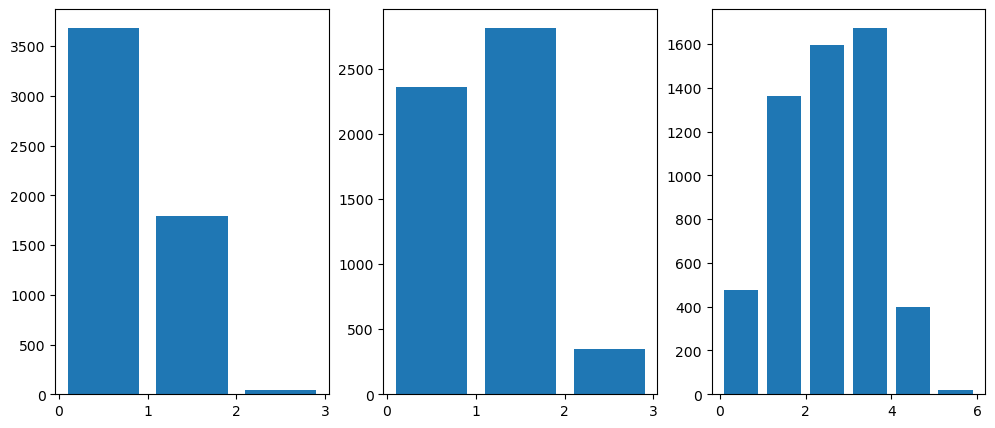

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,5))
ax1.hist(y_ICM,[0,1,2,3], rwidth=0.8)
ax2.hist(y_TE,[0,1,2,3], rwidth=0.8)
ax3.hist(y_Exp,[0,1,2,3,4,5,6], rwidth=0.8)

# Creo el dataset

In [7]:
class EmbryoDataset(Dataset):
    def __init__(self, img_dir, labels, selected_images):
        self.img_labels = labels  # Store the image labels
        self.img_dir = img_dir  # Store the directory containing the images
        self.selected_images = selected_images

        # Define a series of image transformations using torchvision's Compose
        self.transforms = T.Compose([T.ToPILImage(), 
                                T.Pad(100,padding_mode='reflect'), 
                                T.RandomHorizontalFlip(p=0.5), 
                                T.RandomRotation([0, 350], fill=100), 
                                T.CenterCrop(300), 
                                T.ToTensor()])
    def __len__(self):
        return len(self.img_labels)  # Return the total number of images in the dataset

    def __getitem__(self, idx):
        i = self.selected_images[idx]
        img_path = os.path.join(self.img_dir, str(i)+'.jpg')
        image = img_to_array(load_img(img_path))

        image = np.uint8(image.squeeze())
        image = cv2.resize(image, (300,300), interpolation = cv2.INTER_AREA)
        label = self.img_labels[idx]
        image = self.transforms(image)
        
        return image, label


## Load high quality images

In [8]:
selected_size = 1447200
selected_index = []

for i in np.arange(1,n_data+1):

    img_path = os.path.join(directory, str(i)+'.jpg')
    image = img_to_array(load_img(img_path))

    if image.size == selected_size:
        selected_index.append(i)

## Create test y training datasets

In [9]:
def create_dataloaders(labels, selected_index, train_index, val_index, batch_size=32):

    dataset = EmbryoDataset(directory, labels, selected_index)   
    # Divide los datos en conjunto de entrenamiento y validación para este pliegue
    train_dataset = torch.utils.data.Subset(EmbryoDataset, train_index)
    valid_dataset = torch.utils.data.Subset(EmbryoDataset, val_index)

    y_train_indices = train_dataset.indices
    y_train = [dataset.img_labels[i] for i in y_train_indices]
    class_sample_count = np.array([len(np.where(y_train == t)[0]) for t in np.unique(y_train)])

    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in y_train])
    samples_weight = torch.from_numpy(samples_weight)

    weighted_sampler = torch.utils.data.WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

    loader_train = DataLoader(train_dataset, batch_size=batch_size, sampler=weighted_sampler)
    loader_val = DataLoader(valid_dataset, batch_size=batch_size, sampler=sampler.RandomSampler(valid_dataset))

    return loader_train, loader_val


# Training

In [10]:
model_name = 'vgg16'  # Aquí elige el modelo que quieras utilizar

# Define el número de pliegues para la validación cruzada
num_folds = 10  # Por ejemplo, utiliza 10-fold cross-validation
num_folds = 2  # O 2 para ir más rápido en la prueba

# Definición de otros hiperparámetros
learning_rate = 0.001
batch_size = 16
num_epochs = 2

size2 = 1447200
train_proportion = 0.8
valid_proportion = 0.2

labels = y_ICM

In [11]:
# Crea un objeto KFold para dividir tus datos
kf = KFold(n_splits=num_folds, shuffle=True)

# Creación del modelo elegido
model = get_pretrained_model(model_name)

# Resto del código para el entrenamiento
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Seleccionar el optimizador
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Loop sobre los pliegues (folds)
for fold, (train_index, val_index) in enumerate(kf.split(EmbryoDataset)):
    print(f"Fold {fold + 1}/{num_folds}")

    loader_train, loader_val = create_dataloaders(labels, selected_index, train_index, val_index)

    train_loss, train_acc = train_one_epoch(model, optimizer, loader_train, device)
    print(f"Epoch [{fold + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

    val_acc = accuracy(loader_val, model, device)
    print(f"Epoch [{fold + 1}/{num_epochs}], Validation Acc: {val_acc:.4f}")


/Users/jyoung/anaconda3/envs/embryo_segmentation/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/jyoung/anaconda3/envs/embryo_segmentation/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


TypeError: Expected sequence or array-like, got <class 'type'>